# Library

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import random 
import numpy as np
import pandas as pd
from torchinfo import summary
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
import wandb
from dotenv import load_dotenv
from torchvision.datasets import DatasetFolder
from PIL import Image
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from simdinov2.models.return_models import get_dino_finetuned_downloaded

/media/new_volumn/SIMDINOV2_EASYRICE/simdinov2/layers/swiglu_ffn.py:43: UserWarning: Using xFormers (SwiGLU)
  warnings.warn("Using xFormers (SwiGLU)")
/media/new_volumn/SIMDINOV2_EASYRICE/simdinov2/layers/attention.py:27: UserWarning: Using xFormers (Attention)
  warnings.warn("Using xFormers (Attention)")
/media/new_volumn/SIMDINOV2_EASYRICE/simdinov2/layers/attention.py:38: UserWarning: Using SDPA Attention
  warnings.warn("Using SDPA Attention")
/media/new_volumn/SIMDINOV2_EASYRICE/simdinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


# Loading Data

In [2]:
root_nas = '/media/nas/MP/2025/multiple_version2/'
os.listdir(root_nas)

['train_data.csv',
 'test_y_version1.npy',
 'y_valid_split.npy',
 'train_y_version1.npy',
 'y_train_split.npy',
 'x_train_split.npy',
 'x_valid_split.npy',
 'test_data.csv',
 'test_x_version1.npy',
 'train_x_version1.npy']

In [3]:
df_train = pd.read_csv("/media/new_volumn/MP_india/df_count_all_num_images_cleaned.csv") 
saved_dir = "/media/nas/MP/hovernet/Split_Processed/multiple_3class_mali_gk6_gk79"
# Load train and validation datasets

train = np.load(f"{saved_dir}/train_data.npz")
valid = np.load(f"{saved_dir}/valid_data.npz")


In [4]:
x_train = train['x_train']
y_train_keys = train['y_train']

x_valid = valid['x_valid'] 
y_valid_keys = valid['y_valid']

In [5]:
# Create a mapping from 'keys_img_id_ac' to 'Breed'
y_mapping = df_train.set_index('keys_img_id_ac')['Breed'].to_dict() # {"000171_000033": "GK15", }

In [6]:
#Transform y values from keys to Breed, converting GK15 and ML105 to 'Mali'
def transform_breed(breed):
    return "Mali" if breed in ["GK15", "ML105"] else breed
y_train = np.array([transform_breed(y_mapping[key]) for key in y_train_keys if key in y_mapping])
y_valid = np.array([transform_breed(y_mapping[key]) for key in y_valid_keys if key in y_mapping])

# Encode labels using Keras utilities
unique_classes = np.unique(y_train) # extract distinct classes
class_indices = {label: index for index, label in enumerate(unique_classes)} # class with index
y_train_encoded = np.array([class_indices[label] for label in y_train]) # [0, 1, 2, 3, 0, 1, 2, 3, ...]
y_valid_encoded = np.array([class_indices[label] for label in y_valid]) # [0, 1, 2, 3, 0, 1, 2, 3, ...]

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {index: weight for index, weight in enumerate(class_weights)}

In [25]:
class_indices

{np.str_('GK6'): 0, np.str_('GK79'): 1, np.str_('Mali'): 2}

In [7]:
class_weight_dict

{0: np.float64(0.8819021787068889),
 1: np.float64(2.3594395280235987),
 2: np.float64(0.6933572586447525)}

In [8]:
intensity_ranges = {
        "brightness": np.linspace(0.9, 1.1, 5),  # Range should be >0
        "contrast": np.linspace(0.9, 1.1, 5),
        "saturation": np.linspace(0.9, 1.1, 5),  # Ensure positive values
        "hue": np.linspace(-0.05, 0.05, 5)  # Hue range should be (-0.5, 0.5)
        }

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    # transforms.RandomApply(
    # [transforms.ColorJitter(brightness=(intensity_ranges["brightness"].min(), intensity_ranges["brightness"].max()),
    #                         contrast=(intensity_ranges["contrast"].min(), intensity_ranges["contrast"].max()),
    #                         saturation=(intensity_ranges["saturation"].min(), intensity_ranges["saturation"].max()),
    #                         hue=(intensity_ranges["hue"].min(), intensity_ranges["hue"].max()))],
    #                         p=0.8,),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

In [9]:
class NpzDataset(Dataset):
    def __init__(self, npz_path, transforms=None):
        data = np.load(npz_path)
        self.images = data["images"] 
        self.labels = data["labels"]
        self.transforms = transforms
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if image.ndim == 3:
            image = image.transpose(1, 2, 0)  
        image = torch.from_numpy(image).float()
            
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label

In [10]:
type(x_train), x_train.shape

(numpy.ndarray, (79985, 224, 224, 3))

In [11]:
x_train.shape

(79985, 224, 224, 3)

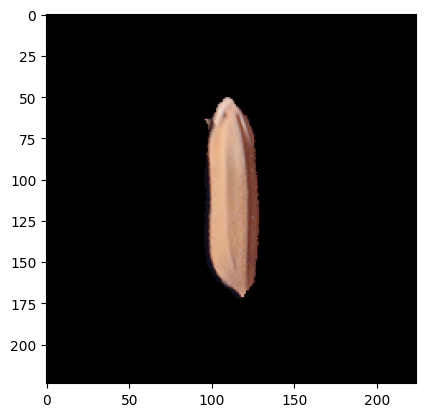

In [12]:
plt.imshow(x_train[0])

In [13]:
model_path = "patch15/eval/training_199999/teacher_checkpoint.pth" # full training
transformer = get_dino_finetuned_downloaded(model_path=model_path, modelname="dinov2_vitb14_reg")
transformer.to("cuda")

Using cache found in /home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Pretrained weights found at patch15/eval/training_199999/teacher_checkpoint.pth and loaded with msg: <All keys matched successfully>


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [14]:
def get_embeddings(data, model):
    embeddings = []

    for image in tqdm(data, desc="Extracting embeddings"):
        model.eval()
        with torch.no_grad():
            image = Image.fromarray(image) # Load image
            image = transform(image)  # Apply normalization
            image = image.unsqueeze(0) # Add batch dimension
            image = transformer(image.to("cuda"))
            embeddings.append(image.cpu().numpy())

    return np.array(embeddings)


In [15]:
train_embeddings = get_embeddings(x_train, transformer)
valid_embeddings = get_embeddings(x_valid, transformer)


Extracting embeddings: 100%|██████████| 20014/20014 [02:06<00:00, 157.60it/s]


In [23]:
np.save("train_embeddings.npy", train_embeddings)
np.save("valid_embeddings.npy", valid_embeddings)

In [16]:
train_embeddings = torch.from_numpy(train_embeddings).float()
valid_embeddings = torch.from_numpy(valid_embeddings).float()

In [17]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data  # NumPy array of images
        self.y_data = y_data  # NumPy array of labels
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):

        embeddings = self.x_data[idx]        
        label = self.y_data[idx]  # Get corresponding label

        return embeddings, torch.tensor(label, dtype=torch.long) 

In [18]:
train_dataset = CustomDataset(train_embeddings, y_train_encoded, None)
valid_dataset = CustomDataset(valid_embeddings, y_valid_encoded, None)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=64)

In [20]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 768]) torch.Size([64])


# Transformer Model Initializing

# Classifier

In [21]:
class TransformerClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        x = x.squeeze(1) # squeeze the second dimension of the embeddings
        logits = self.classifier(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Get predicted labels (taking the class with the highest probability)
        preds = torch.argmax(logits, dim=1)
    
        # Calculate accuracy: Number of correct predictions / Total number of predictions
        correct = (preds == y).sum().item()
        accuracy = correct / y.size(0)  # Divide by batch size to get accuracy

        self.log("train_loss", loss, prog_bar=True)
        wandb.log({"train_loss": loss, "train_acc": accuracy})
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        wandb.log({"val_loss": loss, "val_acc": acc})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)

# Model training

In [24]:
# Initialize model
classifier_model = TransformerClassifier(num_classes=3)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',         # Monitor validation accuracy
    dirpath='checkpoints/15March/',    # Directory to save the checkpoints
    filename='best_model',     # Filename for the best model
    save_top_k=1,              # Save only the best model
    mode='max',                # We want the maximum validation accuracy
)
# Trainer setup
trainer = pl.Trainer(max_epochs=100, 
                     accelerator="gpu" if torch.cuda.is_available() else "mps",
                     callbacks=[checkpoint_callback])

load_dotenv()
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init(project="SIMDINOv2Classifier", name="train2")
#Training
trainer.fit(classifier_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/easyrice/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/easyrice/.netrc
wandb: Currently logged in as: sanchai-mol (easyrice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as t

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | classifier | Sequential       | 230 K  | train
1 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/easyrice/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/easyrice/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


# Confusion Matrix

In [33]:
def predict_and_transform(model, val_loader, df_train, y_valid_keys):
    
    class_indices = {'GK6': 0, 'GK79': 1, 'Mali': 2}
    predictions = []
    

    # Disable gradient computation for inference
    model.to("cuda")
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x_batch = batch[0].to("cuda")
            x_batch = x_batch.squeeze(1)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1)  # Get the predicted class index for each sample
            predictions.extend(preds.cpu().numpy())  # Move back to CPU and store the predictions

    predicted_classes = np.array(predictions)
    
    # Create a mapping from 'keys_img_id_ac' to 'Breed'
    y_mapping = df_train.set_index('keys_img_id_ac')['Breed'].to_dict()
    
    # Transform y values from keys to Breed, converting GK15 and ML105 to 'Mali'
    def transform_breed(breed):
        return "Mali" if breed in ["GK15", "ML105"] else breed
    
    y_valid = np.array([transform_breed(y_mapping[key]) for key in y_valid_keys])
    y_valid = np.array([class_indices[x] for x in y_valid])
    
    return predicted_classes, y_valid

In [34]:
predicted_classes, y_valid = predict_and_transform(classifier_model, val_loader, df_train, y_valid_keys)

In [37]:
def plot_confusion_matrix_percentage(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentage
    cm_percentage = np.nan_to_num(cm_percentage)  # Handle division by zero
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

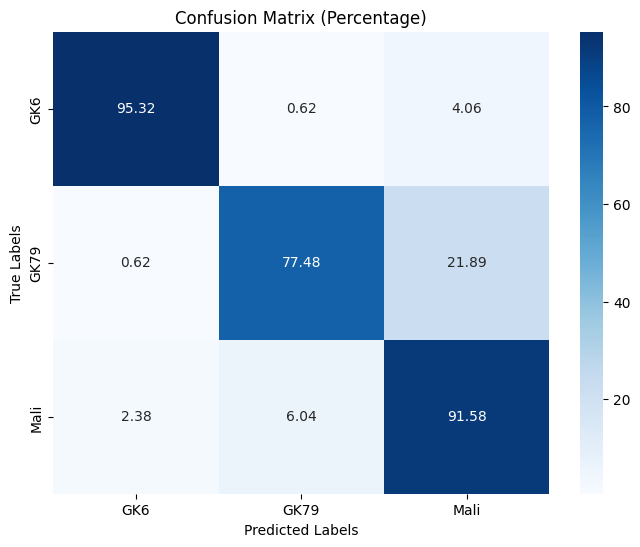

In [38]:
plot_confusion_matrix_percentage(y_valid, predicted_classes, ["GK6", "GK79", "Mali"])